In [1]:
from collections import namedtuple
import numpy as np
import matplotlib.pyplot as plt
import nest
from scaffold.core import from_hdf5
from scaffold.config import JSONConfig
from scaffold.output import HDF5Formatter
from population_view import PopView
import world
from world_populations import Planner, Cortex, SensoryIO, MotorIO, DirectDCN, InverseDCN

In [2]:
# Cerebellum = namedtuple("Cerebellum", "mf io dcn")
Cerebellum = namedtuple("Cerebellum", "mf gr pc io dcn")
Brain = namedtuple("Brain", "planner cortex forward inverse")

In [3]:
CORES = 8

nest.Install("extracerebmodule")

nest.set_verbosity('M_WARNING')
nest.ResetKernel()
nest.SetKernelStatus({'local_num_threads' : CORES,
                      'total_num_virtual_procs' : CORES,
                      'resolution' : 1.0,
                      'overwrite_files' : True})

In [4]:
trial_len = 300
PLAST = True

In [5]:
def create_cortex(MF_number, prism):
    planner_pv = Planner(MF_number, prism)
    cortex_pv = Cortex(MF_number)
    
    planner_pv.connect(cortex_pv)
    
    return planner_pv, cortex_pv

In [6]:
def create_brain(prism):
    hdf5_file = 'scaffold_network_VOR_200.hdf5'
    # hdf5_file = 'scaffold_network_VOR.hdf5'
    # if PLAST:
    #     json_file = 'scaffold_network_VOR_200.json'
    # else:
    #     json_file = 'mouse_cerebellum_200_8t_static.json'

    # reconfigured_obj = JSONConfig(json_file)
    # HDF5Formatter.reconfigure(hdf5_file, reconfigured_obj)
    
    scaffold_model = from_hdf5(hdf5_file)
    scaffold_model.configuration.verbosity = 3

    # Get scaffold model populations
    S_MF = scaffold_model.get_entities_by_type("mossy_fibers")
    S_GR = scaffold_model.get_cells_by_type("granule_cell")[:, 0]
    S_PC = scaffold_model.get_cells_by_type("purkinje_cell")[:, 0]
    S_IO = scaffold_model.get_cells_by_type("io_cell")[:, 0]
    S_DCN = scaffold_model.get_cells_by_type("dcn_cell")[:, 0]

    uz_pos = scaffold_model.labels["microzone-positive"]
    uz_neg = scaffold_model.labels["microzone-negative"]

    S_DCNp = np.intersect1d(S_DCN, uz_pos)
    S_DCNn = np.intersect1d(S_DCN, uz_neg)
    S_IOp = np.intersect1d(S_IO, uz_pos)
    S_IOn = np.intersect1d(S_IO, uz_neg)
    #

    # Prepare adapters
    adapter_forward = scaffold_model.create_adapter("FCN_2019")
    adapter_inverse = scaffold_model.create_adapter("FCN_2019")

    adapter_forward.enable_multi("forward")
    adapter_inverse.enable_multi("reverse")

    adapter_forward.prepare()
    adapter_inverse.prepare()
    #

    # Get NEST populations
    f_IOp = adapter_forward.get_nest_ids(S_IOp)
    f_IOn = adapter_forward.get_nest_ids(S_IOn)

    i_IOp = adapter_inverse.get_nest_ids(S_IOp)
    i_IOn = adapter_inverse.get_nest_ids(S_IOn)

    f_DCNp = adapter_forward.get_nest_ids(S_DCNp)
    f_DCNn = adapter_forward.get_nest_ids(S_DCNn)

    i_DCNp = adapter_forward.get_nest_ids(S_DCNp)
    i_DCNn = adapter_forward.get_nest_ids(S_DCNn)

    f_MF = adapter_forward.get_nest_ids(S_MF)
    i_MF = adapter_inverse.get_nest_ids(S_MF)

    f_GR = adapter_forward.get_nest_ids(S_GR)
    i_GR = adapter_inverse.get_nest_ids(S_GR)

    f_PC = adapter_forward.get_nest_ids(S_PC)
    i_PC = adapter_inverse.get_nest_ids(S_PC)
    #

    # Define population views
    MF_number = len(f_MF)
    # print("MF_number:", MF_number)  # 89

    planner_pv, cortex_pv = create_cortex(MF_number, prism)

    f_IO_pv = SensoryIO(f_IOp, f_IOn)
    i_IO_pv = MotorIO(i_IOp, i_IOn)

    f_DCN_pv = DirectDCN(f_DCNp, f_DCNn)
    i_DCN_pv = InverseDCN(i_DCNp, i_DCNn)

    f_MF_pv = PopView(f_MF)
    i_MF_pv = PopView(i_MF)

    f_GR_pv = PopView(f_GR)
    i_GR_pv = PopView(i_GR)

    f_PC_pv = PopView(f_PC)
    i_PC_pv = PopView(i_PC)
    #

    cortex_pv.connect(f_MF_pv)   # Efference copy
    planner_pv.connect(i_MF_pv)  # Sensory input

    conn_dict = {"rule": "fixed_indegree", "indegree": 1}
    nest.Connect(f_DCNp, cortex_pv.pop, conn_dict, {'weight': 1.0})
    nest.Connect(f_DCNn, cortex_pv.pop, conn_dict, {'weight': -1.0})
    
    forward = Cerebellum(f_MF_pv, f_GR_pv, f_PC_pv, f_IO_pv, f_DCN_pv)
    inverse = Cerebellum(i_MF_pv, i_GR_pv, i_PC_pv, i_IO_pv, i_DCN_pv)
    
    return Brain(planner_pv, cortex_pv, forward, inverse)

In [7]:
# Calibrate
import os.path
import csv

file_name = 'scaffold_200_calibration.csv'
if os.path.isfile(file_name):
    with open(file_name) as f:
        line = f.readline()
        x_0, x_10, open_loop_error = [float(x) for x in line.split(",")]
else:
    nest.ResetKernel()
    brain = create_brain(0.0)

    planner = brain.planner
    cortex = brain.cortex
    
    x_0, x_10, open_loop_error = world.calibrate(planner, cortex)
    
    with open(file_name, 'w') as f:
        f.write("%f,%f,%f\n" % (x_0, x_10, open_loop_error))
    

get_error = world.get_error_function(x_0, x_10)

In [8]:
# nest.ResetKernel()
brain = create_brain(0.0)

Importing  NEST...
Locking NEST kernel...
Installing  NEST modules...
Initializing NEST kernel...
Creating neurons...
Creating io_cell_forward...
Creating 2 io_cell_forward...
Creating dcn_cell_forward...
Creating 6 dcn_cell_forward...
Creating dcn_interneuron_forward...
Creating 6 dcn_interneuron_forward...
Creating golgi_cell_forward...
Creating 54 golgi_cell_forward...
Creating purkinje_cell_forward...
Creating 66 purkinje_cell_forward...
Creating basket_cell_forward...
Creating 98 basket_cell_forward...
Creating stellate_cell_forward...
Creating 201 stellate_cell_forward...
Creating glomerulus_forward...
Creating 1804 glomerulus_forward...
Creating granule_cell_forward...
Creating 22620 granule_cell_forward...
Creating entities...
Creating mossy_fibers_forward...
Creating 89 mossy_fibers_forward...
Building identifier map...
Creating devices...
Creating device:  spike_detector
Connecting to 1804 device targets.
Creating device:  spike_detector
Connecting to 6 device targets.
Creati

In [9]:
planner = brain.planner
cortex = brain.cortex
forward = brain.forward
inverse = brain.inverse

In [10]:
def get_weights(pop1, pop2):
    conns = nest.GetConnections(pop1[::50], pop2[::50])
    weights = nest.GetStatus(conns, "weight")
    return weights

In [11]:
sensory_error = open_loop_error
error_history = []

weights_for = []
weights_inv = []

In [12]:
n_trials = 10
trial_offset = 0

for i in range(n_trials):
    forward.io.set_rate(sensory_error)
    inverse.io.set_rate(sensory_error, trial_i=i+trial_offset)

    print("Simulating")
    nest.Simulate(trial_len)
    print()
    print("Trial ", i+1)
    print()

    x_cortex = cortex.integrate(trial_i=i+trial_offset)

    x_dcn = inverse.dcn.integrate(trial_i=i+trial_offset)
    x_sum = x_cortex + x_dcn

    sensory_error = get_error(x_sum)
    error_history.append(sensory_error)
    print("Closed loop error %d:" % i, sensory_error)

    print()
    print("Forward IO: %.1f" % forward.io.get_per_trial_rate(trial_i=i+trial_offset))
    print("Forward MF: %.1f" % forward.mf.get_per_trial_rate(trial_i=i+trial_offset))
    print("Forward GR: %.1f" % forward.gr.get_per_trial_rate(trial_i=i+trial_offset))
    print("Forward PC: %.1f" % forward.pc.get_per_trial_rate(trial_i=i+trial_offset))
    print("Forward DCN: %.1f" % forward.dcn.get_per_trial_rate(trial_i=i+trial_offset))

    weights = get_weights(forward.gr.pop, forward.pc.pop)
    weights_for.append(weights)
    print("Forward PFPC weights:", min(weights), "to", max(weights))

    print()
    print("Inverse IO: %.1f" % inverse.io.get_per_trial_rate(trial_i=i+trial_offset))
    print("Inverse MF: %.1f" % inverse.mf.get_per_trial_rate(trial_i=i+trial_offset))
    print("Inverse GR: %.1f" % inverse.gr.get_per_trial_rate(trial_i=i+trial_offset))
    print("Inverse PC: %.1f" % inverse.pc.get_per_trial_rate(trial_i=i+trial_offset))
    print("Inverse DCN: %.1f" % inverse.dcn.get_per_trial_rate(trial_i=i+trial_offset))

    weights = get_weights(inverse.gr.pop, inverse.pc.pop)
    weights_inv.append(weights)
    print("Inverse PFPC weights:", min(weights), "to", max(weights))

trial_offset += n_trials

Simulating

Trial  1

Closed loop error 0: 2.847955998739276

Forward IO: 6.7
Forward MF: 169.3
Forward GR: 9.9
Forward PC: 377.2
Forward DCN: 0.0
Forward PFPC weights: 0.007 to 2.4569999999999994

Inverse IO: 3.3
Inverse MF: 9.0
Inverse GR: 0.9
Inverse PC: 88.1
Inverse DCN: 0.0
Inverse PFPC weights: 0.007 to 0.7
Simulating

Trial  2

Closed loop error 1: 1.3916292576947853

Forward IO: 0.0
Forward MF: 172.2
Forward GR: 10.0
Forward PC: 497.2
Forward DCN: 0.0
Forward PFPC weights: 0.007 to 5.20699999999999

Inverse IO: 5.0
Inverse MF: 9.1
Inverse GR: 0.9
Inverse PC: 103.7
Inverse DCN: 0.0
Inverse PFPC weights: 0.007 to 0.7570000000000002
Simulating

Trial  3

Closed loop error 2: 1.1830775798654145

Forward IO: 0.0
Forward MF: 170.1
Forward GR: 9.8
Forward PC: 500.0
Forward DCN: 0.0
Forward PFPC weights: 0.007 to 7.95699999999998

Inverse IO: 0.0
Inverse MF: 9.1
Inverse GR: 0.8
Inverse PC: 114.2
Inverse DCN: 0.0
Inverse PFPC weights: 0.007 to 1.1570000000000005
Simulating

Trial  4

Cl

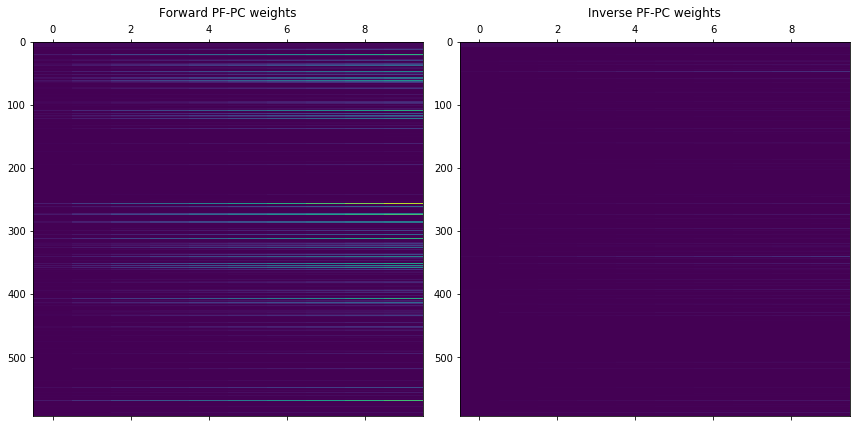

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12,6))


w_max = np.max([np.max(weights_for), np.max(weights_inv)])

axs[0].set_title("Forward PF-PC weights")
axs[0].matshow(np.transpose(weights_for), aspect='auto', vmin=0.0, vmax=30)

axs[1].set_title("Inverse PF-PC weights")
axs[1].matshow(np.transpose(weights_inv), aspect='auto', vmin=0.0, vmax=30)

plt.tight_layout()
plt.show()

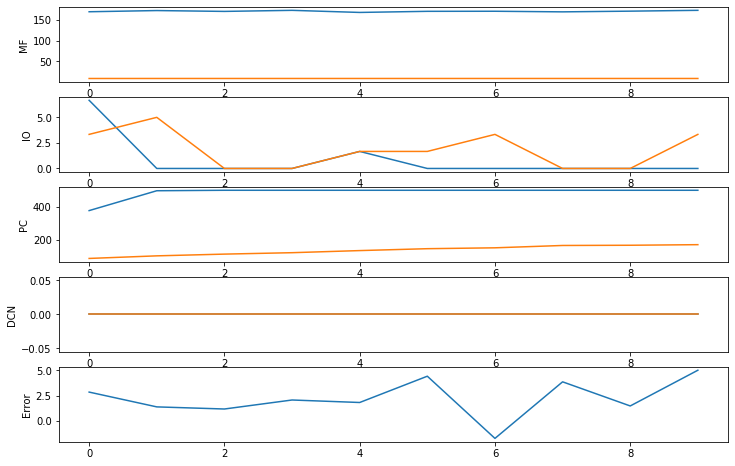

In [14]:
fig, axs = plt.subplots(5, figsize=(12,8))

forward.mf.plot_per_trial_rates('MF', axs[0])
forward.io.plot_per_trial_rates('IO', axs[1])
forward.pc.plot_per_trial_rates('PC', axs[2])
forward.dcn.plot_per_trial_rates('DCN', axs[3])

inverse.mf.plot_per_trial_rates('MF', axs[0])
inverse.io.plot_per_trial_rates('IO', axs[1])
inverse.pc.plot_per_trial_rates('PC', axs[2])
inverse.dcn.plot_per_trial_rates('DCN', axs[3])

axs[4].set_ylabel('Error')
axs[4].plot(error_history)
plt.show()

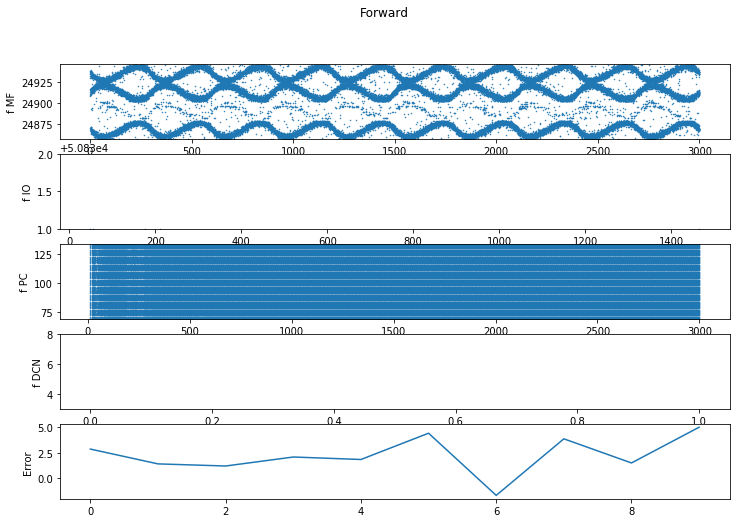

In [15]:
fig, axs = plt.subplots(5, figsize=(12,8))
fig.suptitle("Forward")

forward.mf.plot_spikes((trial_offset-n_trials, trial_offset), 'f MF', axs[0])
forward.io.plot_spikes((trial_offset-n_trials, trial_offset), 'f IO', axs[1])
forward.pc.plot_spikes((trial_offset-n_trials, trial_offset), 'f PC', axs[2])
forward.dcn.plot_spikes((trial_offset-n_trials, trial_offset), 'f DCN', axs[3])

axs[4].set_ylabel('Error')
axs[4].plot(error_history)
plt.show()

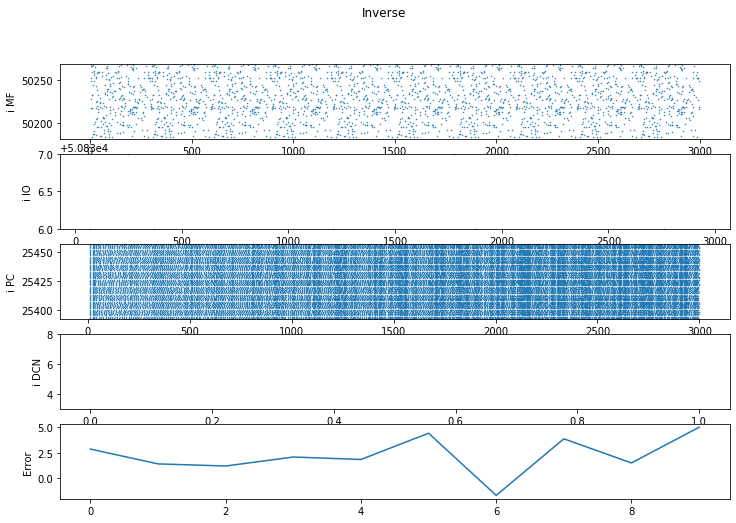

In [16]:
fig, axs = plt.subplots(5, figsize=(12, 8))
fig.suptitle("Inverse")

inverse.mf.plot_spikes((trial_offset-n_trials, trial_offset), 'i MF', axs[0])
inverse.io.plot_spikes((trial_offset-n_trials, trial_offset), 'i IO', axs[1])
inverse.pc.plot_spikes((trial_offset-n_trials, trial_offset), 'i PC', axs[2])
inverse.dcn.plot_spikes((trial_offset-n_trials, trial_offset), 'i DCN', axs[3])

axs[4].set_ylabel('Error')
axs[4].plot(error_history)
plt.show()